In [ ]:
# !tar -xvf ./noisy-train-set.tar -C ./OOD/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset

from PIL import Image
import os
import os.path

from typing import Callable, Optional
import json

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split


In [2]:
def set_seed(seed: int):
    # Set the seed for reproducibility.
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

    

In [3]:
seed = 42
set_seed(seed)

In [4]:
data_root_path = './OOD'

clean_noise_df = pd.read_csv(f'{data_root_path}/image_names_with_index.csv')
clean_noise_df

,small_loss_estimate_clean,confidence_estimate_clean,gmm_estimate_clean,Image Name,Label
0,0,0,0,img_37cdf731-ae5b-4dcb-8c7b-d595e7324fb0.jpg,4
1,0,1,1,img_570bb232-e416-4ed6-908a-bc66412d1a1c.jpg,6
2,1,0,0,img_6ddd443c-3e96-4f29-a04a-245b091d7bd2.jpg,1
3,0,0,0,img_45389146-1ade-4678-a635-6b76f7a22ad7.jpg,0
4,0,1,0,img_52c783df-5462-4225-aa96-c7b7d111706c.jpg,4
...,...,...,...,...,...
30843,0,0,1,img_adff4be7-116e-46e6-9a0b-f30e766be024.jpg,5
30844,1,0,0,img_188eabbb-7c41-44b9-81d7-a4207a2580eb.jpg,9
30845,0,0,0,img_d7fa315d-1348-4cc9-93b4-d0afe4d61d57.jpg,0
30846,0,0,0,img_159a3826-e7c1-40c3-ae69-97d43b0f7188.jpg,8


In [5]:
# data_path = data_root_path + '/training-data'

# idx = 1
# xj_idx = 2

# xi_image_path = os.path.join(data_path, 'imgs', clean_noise_df.loc[idx, 'Image Name'])
# xj_image_path = os.path.join(data_path, 'imgs', clean_noise_df.loc[xj_idx, 'Image Name'])

# # load image
# xi_img = Image.open(xi_image_path).convert('RGB')
# xj_img = Image.open(xj_image_path).convert('RGB')

# # 두 이미지를 동일한 크기로 조정 (여기서는 xi_img의 크기로 맞춤)
# xj_img = xj_img.resize(xi_img.size)

# # 이미지 데이터를 numpy 배열로 변환
# xi_array = np.array(xi_img)
# xj_array = np.array(xj_img)

# # 0.5 비율로 이미지 혼합
# mixup_array = 0.5 * xi_array + 0.5 * xj_array
# mixup_array = mixup_array.astype(np.uint8)  # 정수형으로 변환

# # numpy 배열을 이미지로 변환
# mixup_img = Image.fromarray(mixup_array)

# plt.axis('off')
# plt.imshow(mixup_img)
# plt.show()

# label_map_path = os.path.join(data_path, 'data-labels.json')
# label_map = json.load(open(label_map_path))
# xi_target = label_map[clean_noise_df.loc[idx, 'Image Name'].split('.')[0]]
# xj_target = label_map[clean_noise_df.loc[xj_idx, 'Image Name'].split('.')[0]]
# xk_target = 0.5 * torch.tensor(xi_target) + 0.5 * torch.tensor(xj_target)
# xk_target

In [5]:
sampling_methods = ['gmm'] # 'small_loss', 'confidence', 'gmm'

for sampling_method in sampling_methods:
    column_name = sampling_method + '_estimate_clean'

    train_df = clean_noise_df[clean_noise_df[column_name] == 1].reset_index(drop=True) # clean
    test_df = clean_noise_df[clean_noise_df[column_name] == 0].reset_index(drop=True) # noise, ood

    print(sampling_method)
    print(f'clean: {len(train_df)}')
    print(f'noise and ood: {len(test_df)}')

    valid_df = pd.DataFrame(columns=train_df.columns)
    sample_per_label = len(train_df) // 100

    for label in sorted(train_df['Label'].unique()):
        label_sampled_df = train_df[train_df['Label'] == label].sample(sample_per_label, random_state=42)
        valid_df = pd.concat([valid_df, label_sampled_df], axis= 0)

    train_df = train_df.drop(index=valid_df.index, axis=0)

    train_df.reset_index(drop=True, inplace=True)
    valid_df.reset_index(drop=True, inplace=True)
    # train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['Label'])
    # train_df, valid_df = train_df.reset_index(drop=True), valid_df.reset_index(drop=True)

    print(f'clean train: {len(train_df)}')
    print(f'clean valid: {len(valid_df)}')

gmm
clean: 10578
noise and ood: 20270
clean train: 9528
clean valid: 1050


In [6]:
class NDMixupDataset(VisionDataset):

    def __init__(
            self,
            data_path: str,
            file_df: pd.DataFrame,
            non_mix: bool = False,
            transform: Optional[Callable] = None,
    ) -> None:

        # load data
        self.data_path = data_path
        # list of file names: File name must be this string format "label-filename"
        self.file_df = file_df
        label_map_path = os.path.join(data_path, 'data-labels.json')
        self.label_map = json.load(open(label_map_path))

        self.non_mix = non_mix 
        self.transform = transform
        self.reset_indices()

    def reset_indices(self):
        self.remaining_indices = list(range(len(self.file_df)))
        random.shuffle(self.remaining_indices)

    def __getitem__(self, index: int):
        if self.non_mix:
            xj_index = index

        else:
            if len(self.remaining_indices) == 0:
                self.reset_indices()

            xj_index = self.remaining_indices.pop()
            alpha = random.uniform(0, 1)
        

        xi_image_path = os.path.join(self.data_path, 'imgs', self.file_df.loc[index, 'Image Name'])
        xj_image_path = os.path.join(self.data_path, 'imgs', self.file_df.loc[xj_index, 'Image Name'])
        
        # load image
        xi_img = Image.open(xi_image_path).convert('RGB')
        xj_img = Image.open(xj_image_path).convert('RGB')

        # 두 이미지를 동일한 크기로 조정 (여기서는 xi_img의 크기로 맞춤)
        xj_img = xj_img.resize(xi_img.size)

        # 이미지 데이터를 numpy 배열로 변환
        xi_array = np.array(xi_img)
        xj_array = np.array(xj_img)

        # parsing label
        xi_target = self.label_map[self.file_df.loc[index, 'Image Name'].split('.')[0]]
        xj_target = self.label_map[self.file_df.loc[xj_index, 'Image Name'].split('.')[0]]

        if xi_target != xj_target: # 다른 라벨끼리 mixup
            # 이미지 혼합
            xk_array = alpha * xi_array + (1 - alpha) * xj_array
            xk_array = xk_array.astype(np.uint8)  # 정수형으로 변환

            # numpy 배열을 이미지로 변환
            xk_img = Image.fromarray(xk_array)

            mixing_coefficients = alpha * torch.tensor(xi_target) + (1 - alpha) * torch.tensor(xj_target) # xk_target
            labels = torch.tensor(xi_target) + torch.tensor(xj_target)

        else: 
             # 이미지 혼합
            xk_array = 0.5 * xi_array + 0.5 * xj_array
            xk_array = xk_array.astype(np.uint8)  # 정수형으로 변환

            # numpy 배열을 이미지로 변환
            xk_img = Image.fromarray(xk_array)

            mixing_coefficients = 0.5 * torch.tensor(xi_target) + 0.5 * torch.tensor(xj_target) # xk_target
            labels = mixing_coefficients

        if self.transform is not None:
            xi_img = self.transform(xi_img)
            xj_img = self.transform(xj_img)
            xk_img = self.transform(xk_img)

        if self.non_mix:
            return xi_img, labels, mixing_coefficients    
        
        return torch.cat([xi_img, xj_img, xk_img], dim=1), labels, mixing_coefficients

    def __len__(self) -> int:
        return len(self.file_df)

# the function to transform image to tensors
def make_transforms():

    # we won't apply any data augmentation during the training pipeline, while you need to add augmented images into the datasets
    return transforms.Compose([
        transforms.Resize((64, 64)),
        # ToTensor applies standardization automatically when converting to Tensors.
        transforms.ToTensor(),
    ])


def build(data_path, file_df, non_mix):
    return NDMixupDataset(data_path=data_path, file_df=file_df, non_mix=non_mix, transform=make_transforms())

In [7]:
class VGG16Base(nn.Module):
    def __init__(self, image_size = 64, pretrained=True, num_classes=10):
        super(VGG16Base, self).__init__()
        # Load the pre-trained VGG16 model
        self.features = models.vgg16(pretrained=pretrained).features
    
        self.fc1 = nn.Linear(512 * ((image_size // 32) ** 2 * 3), 512)
        self.fc2 = nn.Linear(512, 1536)
        self.fc3 = nn.Linear(1536, 256)
        self.fc4 = nn.Linear(256, num_classes)

        # Activation and Dropout
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the feature parts
        # input (batch size, 3, image_size, image_size)

        features = self.features(x) # output (batch size, 512, image_size // 32 * 3 , image_size // 32) -> AVgpooling x
        features = torch.flatten(features, 1) #(batch size, 512 * ((image_size // 32) ** 2 * 3))
        
        # Get the features from the classifier part
        x = self.relu(self.fc1(features))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))

        return features, x 

In [8]:
class ConstituencyLoss(nn.Module):
    def __init__(self, g=1000):
        super(ConstituencyLoss, self).__init__()
        self.g = g  # Scaling factor for the loss of the mixing classes

    def forward(self, predictions, labels, mixing_coefficients):
        """
        predictions: output from the network (batch_size, num_classes)
        labels: actual labels for the mixed classes (batch_size, num_classes), 0 or 1
        mixing_coefficients: actual mixing proportions used during mixing (batch_size, num_classes)
        """
        # We assume labels are binary (1 for classes involved in the mix, 0 otherwise)

        # Mask for mixing classes (where labels are 1)
        mix_mask = labels > 0
        
        # Loss for mixing classes: mean squared error on the mixing coefficients
        loss_mix = (predictions[mix_mask] - mixing_coefficients[mix_mask]) ** 2
        
        # Loss for non-mixing classes: should be close to zero
        non_mix_mask = labels == 0
        loss_non_mix = predictions[non_mix_mask] ** 2
        
        # Calculate the total loss with different weights
        loss = (self.g * loss_mix.sum()) + loss_non_mix.sum()
        
        return loss

In [9]:
'''
We use a fixed set of hyperparameter and configuration for fairness in comparison between teams
'''
_lr = 0.00001
_num_classes = 10 
_num_worders = 0
_batch_size = 32
_g = 2000

'''
This can be adjustable.
'''
_total_epochs = 100
early_stop_round = 10

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16Base(pretrained=True, num_classes=_num_classes).to(device)

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=_lr)
loss_fn = ConstituencyLoss(g=_g).to(device)  # Adjust g as necessary

c:\Users\user\anaconda3\envs\ds801\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\ds801\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
train_path = './OOD/training-data' # clean
valid_path = './OOD/training-data' # clean
test_path = './OOD/training-data' # noise & OOD

model_path = './OOD/model'

In [12]:
train_data = build(train_path, train_df, non_mix=False)
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=_batch_size,
                                            shuffle=True,
                                            drop_last=False,
                                            num_workers=_num_worders)

valid_loader = None
if valid_path is not None:
    valid_data = build(valid_path, valid_df, non_mix=False)
    valid_loader = torch.utils.data.DataLoader(valid_data,
                                        batch_size=_batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        num_workers=_num_worders)

In [13]:
num_epochs = _total_epochs  # 에포크 수
early_stop_count = 0
min_loss = float("inf")

for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    valid_loss = 0
    
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):  # train_loader는 훈련 데이터 로더
        model.train()  # 훈련 모드 설정

        inputs, labels, mixing_coefficients = data
        inputs, labels, mixing_coefficients = inputs.to(device), labels.to(device), mixing_coefficients.to(device)
        optimizer.zero_grad()  # 그래디언트 초기화

        # 모델을 통해 입력 데이터에 대한 예측 수행
        _, predictions = model(inputs)
        
        # 손실 계산
        loss = loss_fn(predictions, labels, mixing_coefficients)
        
        # 역전파 수행
        loss.backward()
        
        # 옵티마이저를 통한 파라미터 업데이트
        optimizer.step()
        
        # 총 손실 계산
        train_loss += loss.item()

    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):  # train_loader는 훈련 데이터 로더
            model.eval()  # 훈련 모드 설정

            inputs, labels, mixing_coefficients = data
            inputs, labels, mixing_coefficients = inputs.to(device), labels.to(device), mixing_coefficients.to(device)

            # 모델을 통해 입력 데이터에 대한 예측 수행
            _, predictions = model(inputs)
        
            # 손실 계산
            loss = loss_fn(predictions, labels, mixing_coefficients)

            # 총 손실 계산
            valid_loss += loss.item()           

    if min_loss > valid_loss:
        min_loss = valid_loss
        early_stop_count = 0

        torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }, f'{model_path}/vgg16_{sampling_methods[0]}.pt')

    else:
        early_stop_count += 1

    # 에포크별 손실 출력
    print(f'Epoch {epoch + 1}, train Loss: {train_loss / len(train_loader)}, valid Loss: {valid_loss / len(valid_loader)}, early_stop_count: {early_stop_count}')

    if early_stop_round <= early_stop_count:
        break


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1, train Loss: 11416.133487573406, valid Loss: 11690.315755208334, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2, train Loss: 11008.953829566904, valid Loss: 10493.193152225378, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3, train Loss: 10566.273765205537, valid Loss: 10156.47089547822, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4, train Loss: 9891.29109427433, valid Loss: 9678.683712121212, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5, train Loss: 9204.922913826553, valid Loss: 9169.95743075284, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6, train Loss: 9064.188247168624, valid Loss: 8739.38134765625, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7, train Loss: 8821.734329121226, valid Loss: 8726.018022017046, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8, train Loss: 8570.404685206062, valid Loss: 9166.537656841856, early_stop_count: 1


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9, train Loss: 8346.598921193372, valid Loss: 8391.79580965909, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10, train Loss: 8133.051422733589, valid Loss: 8637.812381628788, early_stop_count: 1


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11, train Loss: 8039.8154296875, valid Loss: 8131.072058475379, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12, train Loss: 7944.2551400613465, valid Loss: 7815.571318655303, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13, train Loss: 7826.401571184197, valid Loss: 7768.488074100379, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14, train Loss: 7552.525778136797, valid Loss: 8035.667939157197, early_stop_count: 1


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15, train Loss: 7626.602168755243, valid Loss: 7509.718616832386, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16, train Loss: 7292.861436267827, valid Loss: 7535.974431818182, early_stop_count: 1


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17, train Loss: 7262.44485617004, valid Loss: 7907.678962476326, early_stop_count: 2


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18, train Loss: 7005.731147919725, valid Loss: 7847.844312263258, early_stop_count: 3


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19, train Loss: 7209.792542732802, valid Loss: 7210.598396070076, early_stop_count: 0


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20, train Loss: 6930.713074959364, valid Loss: 7756.358916311553, early_stop_count: 1


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21, train Loss: 6847.7257309472, valid Loss: 7556.087172999527, early_stop_count: 2


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22, train Loss: 6736.0153792208475, valid Loss: 7496.858220880682, early_stop_count: 3


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23, train Loss: 6647.87353925257, valid Loss: 7462.796416311553, early_stop_count: 4


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24, train Loss: 6561.27952299182, valid Loss: 7773.841767282197, early_stop_count: 5


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25, train Loss: 6514.314816878146, valid Loss: 7465.178784919508, early_stop_count: 6


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26, train Loss: 6474.684300774696, valid Loss: 7498.743045691288, early_stop_count: 7


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27, train Loss: 6309.2032380584105, valid Loss: 7784.448183001894, early_stop_count: 8


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28, train Loss: 6142.812062513108, valid Loss: 7759.889322916667, early_stop_count: 9


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29, train Loss: 6131.713355966863, valid Loss: 7384.072916666667, early_stop_count: 10


In [14]:
# model_path = './OOD/model'
# sampling_methods = ['small_loss'] # 'small_loss', 'confidence', 'gmm'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16Base(pretrained=True, num_classes=_num_classes).to(device)

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=_lr)

checkpoint = torch.load(f'{model_path}/vgg16_{sampling_methods[0]}.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [15]:
prototype_data = build(train_path, train_df, non_mix=True)
prototype_loader = torch.utils.data.DataLoader(prototype_data,
                                            batch_size=_batch_size,
                                            shuffle=False,
                                            drop_last=False,
                                            num_workers=_num_worders)

In [16]:
# 클래스별 특징을 저장할 딕셔너리 초기화
inputs_per_class = {label: [] for label in range(_num_classes)}

# 데이터 로더를 통해 이미지 배치 처리
with torch.no_grad():
    for i, (inputs, labels, _) in tqdm(enumerate(prototype_loader), total=len(prototype_loader)):
        model.eval()  # 훈련 모드 설정
        
        inputs = inputs.to(device)
        
        for input_img, label in zip(inputs, labels):
            index = torch.nonzero(label == 1)[0].item()
            inputs_per_class[index].append(input_img.cpu().numpy())

# 각 클래스별 평균 특징 계산
class_prototypes = {label: np.mean(inputs, axis=0) for label, inputs in inputs_per_class.items()}

  0%|          | 0/298 [00:00<?, ?it/s]

In [17]:
test_data = build(test_path, test_df, non_mix=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                        batch_size=1,
                                        shuffle=False,
                                        drop_last=False,
                                        num_workers=_num_worders)

In [18]:
# 데이터 로더를 통해 이미지 배치 처리
alpha = 0.1
k = 5
maximum_score_dict = {idx: [] for idx in range(len(test_loader))}

with torch.no_grad():
    for i, (querys, _, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        model.eval()  # 훈련 모드 설정
        inputs = torch.cat([querys, querys, querys], dim = 2)

        inputs = inputs.to(device)
        _, predictions= model(inputs)
        _, topk_classes = torch.topk(predictions, k, dim = 1)

        topk_classes = topk_classes.cpu().numpy()[0]
        
        for class_num in topk_classes:
            prototype_exemplar = torch.tensor(class_prototypes[class_num]).unsqueeze(0)
            interpolated_points = (1 - alpha) * torch.tensor(querys.numpy()) + alpha * torch.tensor(class_prototypes[class_num])

            test_inputs = torch.cat([querys, prototype_exemplar, interpolated_points], dim = 2)

            test_inputs = test_inputs.to(device)
            _, membership_predictions= model(test_inputs)

            topk_membership = membership_predictions[:, topk_classes]

            membership_value, membership_class = torch.topk(topk_membership, 1, dim = 1)

            maximum_score_dict[i].append(membership_value.cpu().numpy()[0][0])

membership_score_dict = {idx: np.mean(inputs, axis=0) for idx, inputs in maximum_score_dict.items()}

  0%|          | 0/20270 [00:00<?, ?it/s]

In [20]:
membership_df = pd.DataFrame.from_dict(membership_score_dict, orient='index')
membership_df.columns = [f'{sampling_methods[0]}_score']

membership_df

,gmm_score
0,0.829301
1,0.664841
2,0.625168
3,0.793164
4,0.633296
...,...
20265,0.649919
20266,0.746662
20267,0.646048
20268,0.539803


In [21]:
score_df = pd.concat([test_df, membership_df], axis = 1)

In [22]:
score_df.to_csv(f'./OOD/noise_OOD_{sampling_methods[0]}.csv', index= False)

In [23]:
score_df = pd.read_csv(f'./OOD/noise_OOD_{sampling_methods[0]}.csv')
score_df

,small_loss_estimate_clean,confidence_estimate_clean,gmm_estimate_clean,Image Name,Label,gmm_score
0,0,0,0,img_37cdf731-ae5b-4dcb-8c7b-d595e7324fb0.jpg,4,0.829301
1,1,0,0,img_6ddd443c-3e96-4f29-a04a-245b091d7bd2.jpg,1,0.664840
2,0,0,0,img_45389146-1ade-4678-a635-6b76f7a22ad7.jpg,0,0.625168
3,0,1,0,img_52c783df-5462-4225-aa96-c7b7d111706c.jpg,4,0.793164
4,0,1,0,img_bdc86691-4bbe-4030-b39d-b8ff4c7445e5.jpg,9,0.633296
...,...,...,...,...,...,...
20265,0,0,0,img_e617ac12-87cb-48ae-b5da-36ab3256c7e1.jpg,0,0.649919
20266,1,0,0,img_0767b136-5057-4bde-9000-e6da05990f00.jpg,1,0.746662
20267,1,0,0,img_188eabbb-7c41-44b9-81d7-a4207a2580eb.jpg,9,0.646048
20268,0,0,0,img_d7fa315d-1348-4cc9-93b4-d0afe4d61d57.jpg,0,0.539803


In [24]:
score_df.describe()

,small_loss_estimate_clean,confidence_estimate_clean,gmm_estimate_clean,Label,gmm_score
count,20270.000000,20270.000000,20270.0,20270.000000,20270.000000
mean,0.296547,0.273409,0.0,4.221263,0.717891
std,0.456746,0.445720,0.0,2.772071,0.087348
min,0.000000,0.000000,0.0,0.000000,0.489951
25%,0.000000,0.000000,0.0,2.000000,0.647718
50%,0.000000,0.000000,0.0,4.000000,0.719038
75%,1.000000,1.000000,0.0,7.000000,0.785701
max,1.000000,1.000000,0.0,9.000000,0.960179


In [28]:
score_df[score_df[f'{sampling_methods[0]}_score'] == score_df[f'{sampling_methods[0]}_score'].min()]

,small_loss_estimate_clean,confidence_estimate_clean,gmm_estimate_clean,Image Name,Label,gmm_score
18114,0,0,0,img_1af526ab-3cb4-49c6-a661-2a64eeebeb47.jpg,8,0.489951


In [29]:
min_idx = score_df[score_df[f'{sampling_methods[0]}_score'] == score_df[f'{sampling_methods[0]}_score'].min()].index[0]
max_idx = score_df[score_df[f'{sampling_methods[0]}_score'] == score_df[f'{sampling_methods[0]}_score'].max()].index[0]

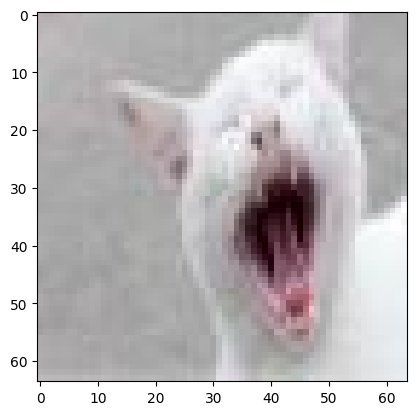

In [30]:
image_path = os.path.join(test_path, 'imgs', clean_noise_df.loc[min_idx, 'Image Name'])
# xj_image_path = os.path.join(data_path, 'imgs', clean_noise_df.loc[xj_idx, 'Image Name'])

# # load image
img = Image.open(image_path).convert('RGB')
# xj_img = Image.open(xj_image_path).convert('RGB')

plt.imshow(img)